# 机器学习实战 学习笔记 —— kNN
[K近邻算法详解](http://www.mwhitelab.com/page/3)

代码修改及批注：[M小白](mwhitelab.com)

更多内容见**技术杂学铺**微信公众号

In [1]:
import numpy as np # 书中为 from numpy import * ，很不建议这样使用
import operator

### 任务一：电影种类识别

In [2]:
# 加载数据
def createDataSet():
    group = np.array([[1.0,1.1],[1.0,1.0],[0,0],[0,0.1]])
    labels = ['A', 'A', 'B', 'B']
    return group, labels

In [3]:
group, labels = createDataSet()
print(group)
print(labels)

[[1.  1.1]
 [1.  1. ]
 [0.  0. ]
 [0.  0.1]]
['A', 'A', 'B', 'B']


In [4]:
# K近邻算法  距离采用L2范数计算，也可以采用其他
def classify0(inX, dataSet, labels, k):
    '''
    K近邻算法 classify0
    inX -- 被分类向量
    dataSet -- 样本特征值集
    labels -- 样本标签集
    k -- K近邻算法k值
    '''
    dataSetSize = dataSet.shape[0]                  # 获得样本数；dataSet.shape = [样本数，每个样本的维度]
    diffMat = np.tile(inX, (dataSetSize,1)) - dataSet  # tile 把inX扩展，在第0个轴上复制inX dataSetSize倍，在第1个轴上复制inX 1倍；tile使用方法见下一运算格。
    sqDiffMat = diffMat ** 2
    sqDistances = sqDiffMat.sum(axis=1)             # 沿第1个轴求和
    distances = sqDistances ** 0.5                  # 计算各点之间距离
    sortedDistIndicies = distances.argsort()        # 距离远近排序,返回一个由1-n,共n个整数组成的array.第k个值代表distances中第k小的索引
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]  # 获取前k近的点的labels，巧妙
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1  # 字典.get(key,0) 如果字典里有key，则返回key的value，若没有key，则返回0
    sortedClassCount = sorted(classCount.items(),key=lambda x:x[1],reverse=True)  # 排序，返回的是元组
    return sortedClassCount[0][0]

In [5]:
# Numpy 中的 tile的使用方法
np.tile([2,3],(2,1))

array([[2, 3],
       [2, 3]])

In [6]:
# sort的使用方法
dict_={'a':-2,'b':9,'c':1,'d':-4}
list_= sorted(dict_.items(),key=lambda x:x[1],reverse=True) 
# dict_.items()表示排序字典的（key,value）
# key=lambda x:x[1]表示以（key,value）中第1个值排序（key为第0个值，value为第1个值，因此，以value的值排序）
# reverse = True 表示从大到小排序。改为false或不写该项则为从小到大
print(list_)

[('b', 9), ('c', 1), ('a', -2), ('d', -4)]


In [7]:
# 使用classify0函数 查看当k=3时，点[0,0]的类别
group, labels = createDataSet()
classify0([0,0], group, labels, 3) 

'B'

### 任务二： 约会网站匹配
##### 2.1 数据处理与分析

In [8]:
# 处理txt文本，转换为Numpy的矩阵数据
def file2matrix(filename):                          #将文件内容转化为矩阵
    fr = open(filename)                             #打开、读入文件
    arrayOLines = fr.readlines()                    #自动将文件内容分析成一个行的列表
    numberOfLines = len(arrayOLines)                #获取文件行数
    returnMat = np.zeros((numberOfLines,3))            #创建一个行数和读取数据的行数一样，列数为3的元素全为0的矩阵
    classLabelVector = []                           #创建列表

    #解析文件数据到列表
    index = 0
    for line in arrayOLines:
        line = line.strip()                         #移除字符串头尾指定的字符（默认为空格）,截取掉回车字符
        listFromLine = line.split('\t')             #以\t为分隔符，把读入的数据分成列数为4的矩阵
        returnMat[index,:] = listFromLine[0:3]      #把数据放入新构建的矩阵中，导入0,1,2列，没有3（0开始，3之前，不包含3）
        classLabelVector.append(int(listFromLine[-1])) 
                                                    #负数表示从后往前取，取最后一个元素，并且注明其为int（默认为string）
        index += 1
    return returnMat,classLabelVector               #返回输入特征向量与标签

In [9]:
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
print(datingDataMat)      # 特征
print(datingLabels[0:20]) # 前20个样本的标签

[[4.0920000e+04 8.3269760e+00 9.5395200e-01]
 [1.4488000e+04 7.1534690e+00 1.6739040e+00]
 [2.6052000e+04 1.4418710e+00 8.0512400e-01]
 ...
 [2.6575000e+04 1.0650102e+01 8.6662700e-01]
 [4.8111000e+04 9.1345280e+00 7.2804500e-01]
 [4.3757000e+04 7.8826010e+00 1.3324460e+00]]
[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]


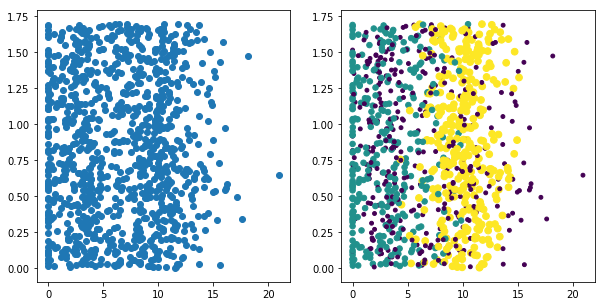

In [12]:
# 绘图分析数据
import matplotlib
import matplotlib.pyplot as plt

# 查看第二列数据与第三列数据的相关性
fig = plt.figure(figsize=(10,5))                             # 设置图像大小
ax1 = fig.add_subplot(121)                                   # 添加子图
ax1.scatter(datingDataMat[:,1],datingDataMat[:,2])           # 散点图
ax2 = fig.add_subplot(122)
ax2.scatter(datingDataMat[:,1],datingDataMat[:,2],15.0*np.array(datingLabels),15.0*np.array(datingLabels)) # 四个参数分别为：特征X，标记y，点的大小，点的颜色
plt.show()

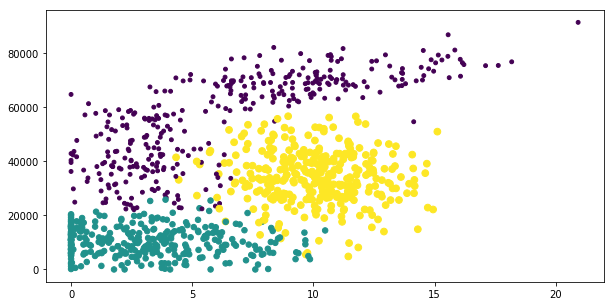

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(datingDataMat[:,1],datingDataMat[:,0],15.0*np.array(datingLabels),15.0*np.array(datingLabels)) 
plt.show()

##### 2.2 特征工程——归一化数据：

In [13]:
# 数据归一化处理
# 数据归一到[0,1]  也可以采用其他归一数据的办法
def autoNorm(dataSet):                              # 数据归一 
    minVals = dataSet.min(0)                        # 0代表选择当前列最小，输入m*n矩阵，返回1*n矩阵
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))       # 构建一个和dataSet同样大小的矩阵
    m = dataSet.shape[0]                            # 获得行数（样本数），也可以normDataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals,(m,1))  # tile 一个构造矩阵的函数 这里用不用tile都可以
    normDataSet = normDataSet/np.tile(ranges,(m,1)) # 元素间的相除
    return normDataSet, ranges, minVals

In [14]:
normMat, ranges, minVals = autoNorm(datingDataMat)
print(normMat, ranges, minVals)

[[0.44832535 0.39805139 0.56233353]
 [0.15873259 0.34195467 0.98724416]
 [0.28542943 0.06892523 0.47449629]
 ...
 [0.29115949 0.50910294 0.51079493]
 [0.52711097 0.43665451 0.4290048 ]
 [0.47940793 0.3768091  0.78571804]] [9.1273000e+04 2.0919349e+01 1.6943610e+00] [0.       0.       0.001156]


##### 2.3 评估算法

In [15]:
# 封装整合kNN代码
def datingClassTest():                                # 显示算法测试错误率
    hoRatio = 0.10                                    # 抽取数据在总数据中的比例
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')  # 获取数据                                                     
    normMat, ranges, minVals = autoNorm(datingDataMat)# 获取归一化后的数据
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)                      # 测试数据的个数
    errorCount = 0.0
    for i in range(numTestVecs):                      # 对每个测试数据，都进行一次K近临算法，并比较结果是否相同。datingDataMat中前numTestVecs个数据构成测试集，其他数据构成训练集
        classifierResult = classify0(normMat[i,:],normMat[numTestVecs:m,:],datingLabels[numTestVecs:m],5) # 数据中[numTestVecs:m,:]，训练数据不包含测试集                                                      
        # print "the classifier came back with: %d, the real answer is: %d" % (classifierResult, datingLabels[i])
        if (classifierResult != datingLabels[i]): errorCount += 1.0
    print("the total error rate is: %f" % (errorCount/float(numTestVecs)))

In [16]:
datingClassTest()

the total error rate is: 0.050000


##### 2.4 应用

In [17]:
# 应用
def classifyPerson():
    resultList = ['not at all', 'in small doses', 'in large doses']
    percentTats = float(input("percentage of time spent playing video games? "))  # 通过键盘输入，获取值
    ffMiles = float(input("frequent flier miles earned per year? "))
    iceCream = float(input("liters of ice cream consumed per year? "))
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    inArr = np.array([ffMiles, percentTats, iceCream])
    classifierResult = classify0((inArr-minVals)/ranges,normMat,datingLabels,3)
                                                    #输入归一化(inArr-minVals)/ranges 很重要，minCals ranges由已由大量数据得出
                                                    # 由于训练数据进行了特征工程处理，我们需要预测的数据也要进行相应的特征工程处理
    print("You will probably like this person: ", resultList[classifierResult - 1])


In [18]:
# 模型应用 需要输入数值
classifyPerson()

percentage of time spent playing video games? 10
frequent flier miles earned per year? 3000
liters of ice cream consumed per year? 2
You will probably like this person:  in small doses


### 任务三： 手写识别系统

In [19]:
def img2vector(filename):                            #将文件内容转换为矩阵
    returnVect = np.zeros((1,1024))                  #是array，不是list，所以是[0,32*i+j]而不是[32*i+j]
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect


In [23]:
from os import listdir
def handwritingClassTest():
    hwLabels = []                                       # 标签集
    trainingFileList = listdir('digits/trainingDigits') # 建立一个trainingFileList的List，list中每个元素是文件中文件名，是字符串                                                     
    # 获取训练数据集
    m = len(trainingFileList)                           # len 获取对象的长度
    trainingMat = np.zeros((m,1024))                    
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]             # split,将字符串以"."分开，结果为一个list。[0]表示第一个"."以前的内容
        classNumStr = int(fileStr.split('_')[0])        # 获取类别
        hwLabels.append(classNumStr)
        trainingMat[i,:] = img2vector('digits/trainingDigits/%s' % fileNameStr) # 加载数据 
    testFileList = listdir('digits/testDigits')
    errorCount = 0.0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector('digits/testDigits/%s' % fileNameStr)
        # 评估
        classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 3)
        # print("the classifier came back with: %d, the real answer is: %d" % (classifierResult, classNumStr))
        if(classifierResult != classNumStr): errorCount += 1.0
    print ("\nthe total number of errors is: %d" % errorCount)
    print ("\nthe total error rate is: %f" % (errorCount/float(mTest)))  # 分母不转化为float也可以，分子分母只要有一个为float，结果为float。int/int结果为int                                           

In [24]:
# 需要执行一段时间
handwritingClassTest()


the total number of errors is: 10

the total error rate is: 0.010571
